In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from collections import Counter, defaultdict
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from tqdm import tqdm
from PIL import Image
import random
import os
import gradio as gr



In [14]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
train_data_path = '/kaggle/input/brain-tumerr/brain tumer/Training'
test_data_path  = '/kaggle/input/brain-tumerr/brain tumer/Testing'

# Raw datasets
train_dataset_raw = datasets.ImageFolder(root=train_data_path)
test_dataset_raw  = datasets.ImageFolder(root=test_data_path)
class_names = train_dataset_raw.classes
num_classes = len(class_names)


=== Class Distribution ===


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


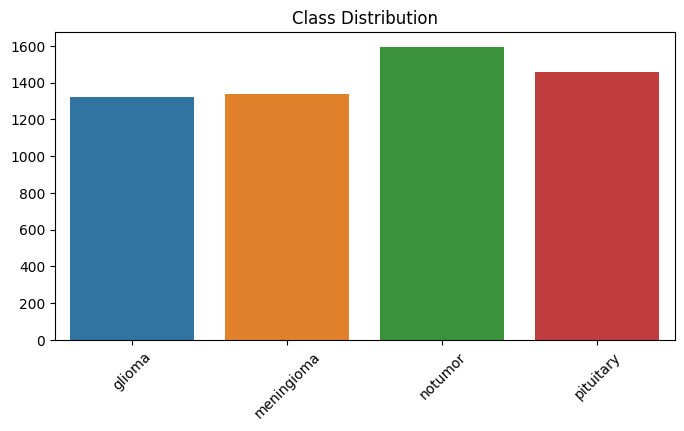

=== Image Size Stats ===
Width:  min=150, max=1920, mean=451.6
Height: min=168, max=1446, mean=453.9


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


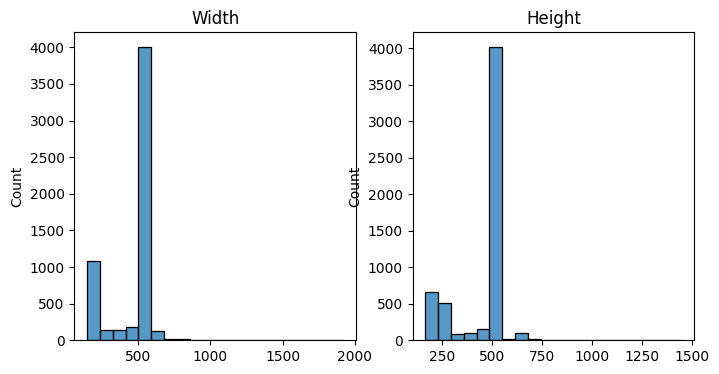

=== Pixel Stats ===
Per-channel mean: [0.18586493 0.18586768 0.18591332]
Per-channel std:  [0.1854428  0.18543972 0.18546872]
=== Random Samples ===


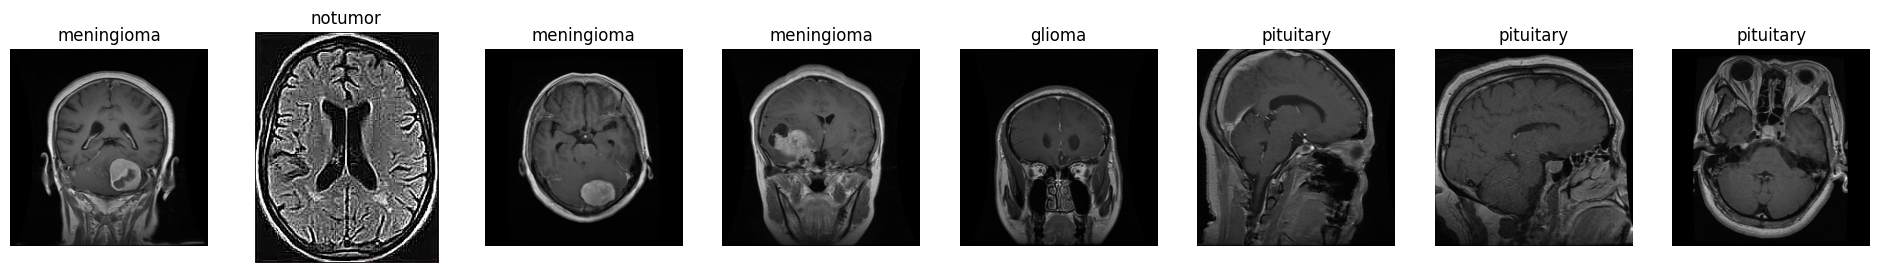

=== One per Class ===


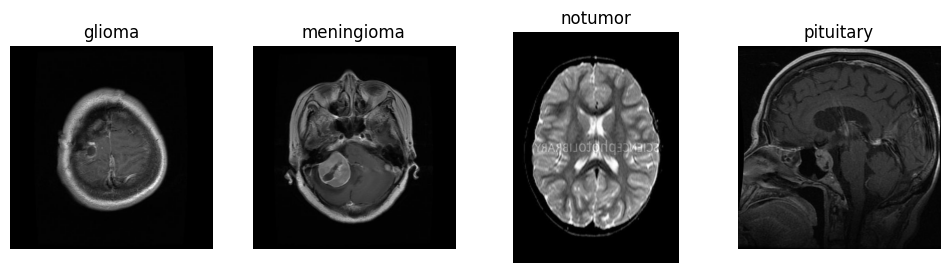

In [15]:
# EDA Functions 
def plot_class_distribution(dataset_raw):
    counts = Counter(label for _, label in dataset_raw)
    plt.figure(figsize=(8,4))
    sns.barplot(x=[class_names[i] for i in counts.keys()],
                y=[counts[i] for i in counts.keys()])
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.show()

def image_size_stats(dataset_raw):
    widths, heights = [], []
    for path, _ in dataset_raw.imgs:
        w, h = Image.open(path).size
        widths.append(w); heights.append(h)
    print(f"Width:  min={np.min(widths)}, max={np.max(widths)}, mean={np.mean(widths):.1f}")
    print(f"Height: min={np.min(heights)}, max={np.max(heights)}, mean={np.mean(heights):.1f}")
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); sns.histplot(widths, bins=20); plt.title("Width")
    plt.subplot(1,2,2); sns.histplot(heights, bins=20); plt.title("Height")
    plt.show()

def compute_pixel_stats(dataset_raw, sample_size=500):
    idxs = random.sample(range(len(dataset_raw)), min(sample_size, len(dataset_raw)))
    means, stds = [], []
    to_tensor = transforms.ToTensor()
    for idx in idxs:
        img, _ = dataset_raw[idx]
        t = to_tensor(img)
        means.append(t.mean(dim=[1,2]).numpy())
        stds.append(t.std(dim=[1,2]).numpy())
    means = np.stack(means); stds = np.stack(stds)
    print("Per-channel mean:", means.mean(axis=0))
    print("Per-channel std: ", stds.mean(axis=0))

def visualize_random_samples(dataset_raw, num_samples=8):
    indices = list(range(len(dataset_raw)))
    random.shuffle(indices)
    fig, axes = plt.subplots(1, num_samples, figsize=(3*num_samples, 3))
    for i, idx in enumerate(indices[:num_samples]):
        img, lbl = dataset_raw[idx]
        axes[i].imshow(img); axes[i].set_title(class_names[lbl]); axes[i].axis('off')
    plt.show()

def visualize_one_per_class(dataset_raw):
    class_indices = defaultdict(list)
    for idx, (_, lbl) in enumerate(dataset_raw):
        class_indices[lbl].append(idx)
    fig, axes = plt.subplots(1, len(class_names), figsize=(3*len(class_names), 3))
    for cls, ax in zip(class_indices, axes):
        idx = random.choice(class_indices[cls])
        img, lbl = dataset_raw[idx]
        ax.imshow(img); ax.set_title(class_names[lbl]); ax.axis('off')
    plt.show()

# EDA
print("=== Class Distribution ==="); plot_class_distribution(train_dataset_raw)
print("=== Image Size Stats ==="); image_size_stats(train_dataset_raw)
print("=== Pixel Stats ==="); compute_pixel_stats(train_dataset_raw)
print("=== Random Samples ==="); visualize_random_samples(train_dataset_raw)
print("=== One per Class ==="); visualize_one_per_class(train_dataset_raw)


In [16]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0), ratio=(0.75,1.33)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.02*torch.randn_like(x)),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: torch.clamp(x, -1.0,1.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02,0.2), ratio=(0.3,3.3)),
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.02*torch.randn_like(x)),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: torch.clamp(x, -1.0,1.0)),
])

# Datasets & Loaders
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transform)
test_dataset  = datasets.ImageFolder(root=test_data_path,  transform=test_transform)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [17]:
def train_model(model, loader, criterion, optimizer, epochs=10):
    model.to(device).train()
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        for imgs, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch {epoch+1}: Loss={running_loss/total:.4f}, Acc={100*correct/total:.2f}%")
    return model

def evaluate_model(model, loader):
    model.to(device).eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    acc  = accuracy_score(all_labels, all_preds) * 100
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec  = recall_score(all_labels, all_preds, average='weighted')
    f1   = f1_score(all_labels, all_preds, average='weighted')
    print(f"Test Acc: {acc:.2f}% | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
    plt.show()


In [18]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channel, channel//reduction)
        self.fc2 = nn.Linear(channel//reduction, channel)
    def forward(self, x):
        b, c, _, _ = x.size()
        s = x.view(b, c, -1).mean(dim=2)
        e = F.relu(self.fc1(s))
        e = torch.sigmoid(self.fc2(e)).view(b, c, 1, 1)
        return x * e


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/3736231680.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Epoch 1: Loss=0.4842, Acc=81.99%


Epoch 2/10: 100%|██████████| 179/179 [01:54<00:00,  1.56it/s]


Epoch 2: Loss=0.2233, Acc=92.45%


Epoch 3/10: 100%|██████████| 179/179 [01:54<00:00,  1.56it/s]


Epoch 3: Loss=0.1684, Acc=94.28%


Epoch 4/10: 100%|██████████| 179/179 [01:56<00:00,  1.54it/s]


Epoch 4: Loss=0.1521, Acc=95.34%


Epoch 5/10: 100%|██████████| 179/179 [01:55<00:00,  1.55it/s]


Epoch 5: Loss=0.1318, Acc=95.61%


Epoch 6/10: 100%|██████████| 179/179 [01:55<00:00,  1.55it/s]


Epoch 6: Loss=0.1177, Acc=96.41%


Epoch 7/10: 100%|██████████| 179/179 [01:55<00:00,  1.55it/s]


Epoch 7: Loss=0.0948, Acc=96.81%


Epoch 8/10: 100%|██████████| 179/179 [01:55<00:00,  1.55it/s]


Epoch 8: Loss=0.0856, Acc=97.06%


Epoch 9/10: 100%|██████████| 179/179 [01:54<00:00,  1.56it/s]


Epoch 9: Loss=0.0824, Acc=97.20%


Epoch 10/10: 100%|██████████| 179/179 [01:55<00:00,  1.55it/s]


Epoch 10: Loss=0.0962, Acc=96.92%
Test Acc: 99.47% | Prec: 0.9947 | Rec: 0.9947 | F1: 0.9947


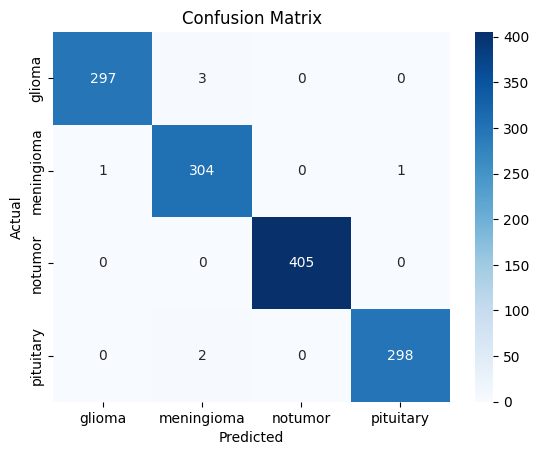

In [19]:
class CNN_Transformer_Hybrid(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        backbone = models.resnet50(pretrained=False)
        wpath = '/kaggle/input/brain-tumerr/resnet50-11ad3fa6.pth'
        if os.path.exists(wpath):
            backbone.load_state_dict(torch.load(wpath, map_location=device), strict=False)
        self.cnn         = nn.Sequential(*list(backbone.children())[:-2])
        self.se          = SEBlock(2048)
        self.pool        = nn.AdaptiveAvgPool2d((1,1))
        self.token       = nn.Linear(2048, 512)
        self.drop1       = nn.Dropout(0.3)
        enc               = nn.TransformerEncoderLayer(d_model=512, nhead=8,
                                                      batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(enc, num_layers=4)
        self.drop2       = nn.Dropout(0.3)
        self.fc          = nn.Linear(512, num_classes)
    def forward(self, x):
        f = self.cnn(x)
        f = self.se(f)
        f = self.pool(f).view(f.size(0), -1)
        t = self.drop1(self.token(f)).unsqueeze(1)
        t = self.transformer(t).mean(dim=1)
        return self.fc(self.drop2(t))

# Instantiate & train
counts        = Counter([lbl for _, lbl in train_dataset])
weights       = torch.tensor([len(train_dataset)/(num_classes*counts[i])
                              for i in range(num_classes)], device=device)
model_resnet  = CNN_Transformer_Hybrid(num_classes).to(device)
train_model(model_resnet, train_loader,
            nn.CrossEntropyLoss(weight=weights),
            optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=1e-4),
            epochs=10)
evaluate_model(model_resnet, test_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/2999381282.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Epoch 1: Loss=0.4861, Acc=82.32%


Epoch 2/10: 100%|██████████| 179/179 [01:18<00:00,  2.28it/s]


Epoch 2: Loss=0.2860, Acc=90.09%


Epoch 3/10: 100%|██████████| 179/179 [01:18<00:00,  2.29it/s]


Epoch 3: Loss=0.2170, Acc=92.49%


Epoch 4/10: 100%|██████████| 179/179 [01:18<00:00,  2.27it/s]


Epoch 4: Loss=0.1666, Acc=94.45%


Epoch 5/10: 100%|██████████| 179/179 [01:19<00:00,  2.25it/s]


Epoch 5: Loss=0.1508, Acc=94.92%


Epoch 6/10: 100%|██████████| 179/179 [01:18<00:00,  2.27it/s]


Epoch 6: Loss=0.1398, Acc=95.27%


Epoch 7/10: 100%|██████████| 179/179 [01:18<00:00,  2.27it/s]


Epoch 7: Loss=0.1318, Acc=95.73%


Epoch 8/10: 100%|██████████| 179/179 [01:18<00:00,  2.28it/s]


Epoch 8: Loss=0.1132, Acc=96.43%


Epoch 9/10: 100%|██████████| 179/179 [01:17<00:00,  2.30it/s]


Epoch 9: Loss=0.1025, Acc=96.73%


Epoch 10/10: 100%|██████████| 179/179 [01:16<00:00,  2.33it/s]


Epoch 10: Loss=0.0974, Acc=96.97%
Test Acc: 97.79% | Prec: 0.9787 | Rec: 0.9779 | F1: 0.9780


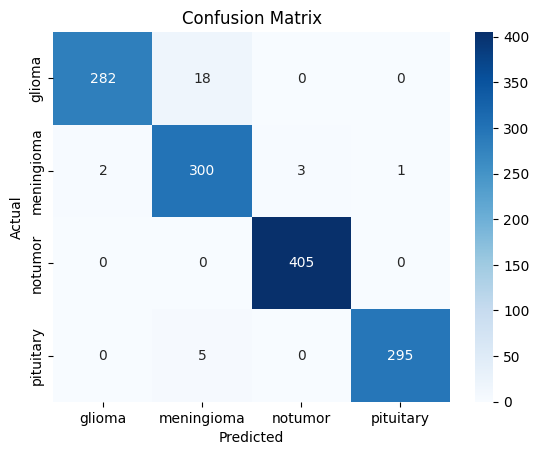

In [20]:
class EfficientNet_Transformer_Hybrid(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        eff = models.efficientnet_b0(pretrained=False)
        wpath = '/kaggle/input/brain-tumerr/efficientnet_b0.pth'
        if os.path.exists(wpath):
            eff.load_state_dict(torch.load(wpath, map_location=device))
        self.cnn         = eff.features
        self.se          = SEBlock(1280)
        self.pool        = nn.AdaptiveAvgPool2d((1,1))
        self.token       = nn.Linear(1280, 512)
        self.drop1       = nn.Dropout(0.3)
        enc               = nn.TransformerEncoderLayer(d_model=512, nhead=8,
                                                      batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(enc, num_layers=4)
        self.drop2       = nn.Dropout(0.3)
        self.fc          = nn.Linear(512, num_classes)
    def forward(self, x):
        f = self.cnn(x)
        f = self.se(f)
        f = self.pool(f).view(f.size(0), -1)
        t = self.drop1(self.token(f)).unsqueeze(1)
        t = self.transformer(t).mean(dim=1)
        return self.fc(self.drop2(t))

# Instantiate & train
weights_eff  = torch.tensor([len(train_dataset)/(num_classes*counts[i])
                              for i in range(num_classes)], device=device)
model_eff    = EfficientNet_Transformer_Hybrid(num_classes).to(device)
train_model(model_eff, train_loader,
            nn.CrossEntropyLoss(weight=weights_eff),
            optim.Adam(model_eff.parameters(), lr=1e-4, weight_decay=1e-4),
            epochs=10)
evaluate_model(model_eff, test_loader)


In [21]:
# Grad-CAM & Saliency
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.layer = target_layer
        self.grad, self.act = None, None
        self.h1 = self.layer.register_forward_hook(
            lambda m, i, o: setattr(self, 'act', o.detach()))
        self.h2 = self.layer.register_backward_hook(
            lambda m, gi, go: setattr(self, 'grad', go[0].detach()))
    def remove_hooks(self):
        self.h1.remove()
        self.h2.remove()
    def __call__(self, x, class_idx=None):
        out = self.model(x)
        if class_idx is None:
            class_idx = out.argmax(dim=1).item()
        one_hot = torch.zeros_like(out)
        one_hot[0, class_idx] = 1
        self.model.zero_grad()
        out.backward(gradient=one_hot, retain_graph=True)
        w   = self.grad.mean(dim=[2,3], keepdim=True)
        cam = F.relu((w * self.act).sum(dim=1, keepdim=True))
        cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
        cam = F.interpolate(cam, size=(224,224), mode='bilinear', align_corners=False)
        return cam.cpu().numpy()[0,0], class_idx

def compute_saliency(model, x, class_idx=None):
    x.requires_grad_()
    out = model(x)
    if class_idx is None:
        class_idx = out.argmax(dim=1).item()
    val = out[0, class_idx]
    model.zero_grad()
    val.backward()
    sal, _ = torch.max(x.grad.abs(), dim=1)
    sal = (sal - sal.min())/(sal.max()-sal.min()+1e-8)
    return sal.squeeze().cpu().numpy(), class_idx

def visualize_gradcam_and_saliency(model, img_path, transform, classes):
    img = Image.open(img_path).convert("RGB")
    inp = transform(img).unsqueeze(0).to(device)

    # pick whichever attribute your model has
    backbone = getattr(model, 'cnn_backbone', None) or getattr(model, 'cnn')
    layer    = backbone[-1]

    gc, _ = GradCAM(model, layer), layer
    cam, pred = gc(inp)
    sal, _    = compute_saliency(model, inp, pred)
    gc.remove_hooks()

    fig, ax = plt.subplots(1,3, figsize=(18,6))
    ax[0].imshow(img)
    ax[0].set_title(f"Original\nPred: {classes[pred]}")
    ax[0].axis('off')

    ax[1].imshow(img)
    ax[1].imshow(cam, cmap='jet', alpha=0.5)
    ax[1].set_title("Grad-CAM")
    ax[1].axis('off')

    ax[2].imshow(sal, cmap='hot')
    ax[2].set_title("Saliency")
    ax[2].axis('off')

    plt.show()



>>> Visualizing on CNN_Transformer_Hybrid


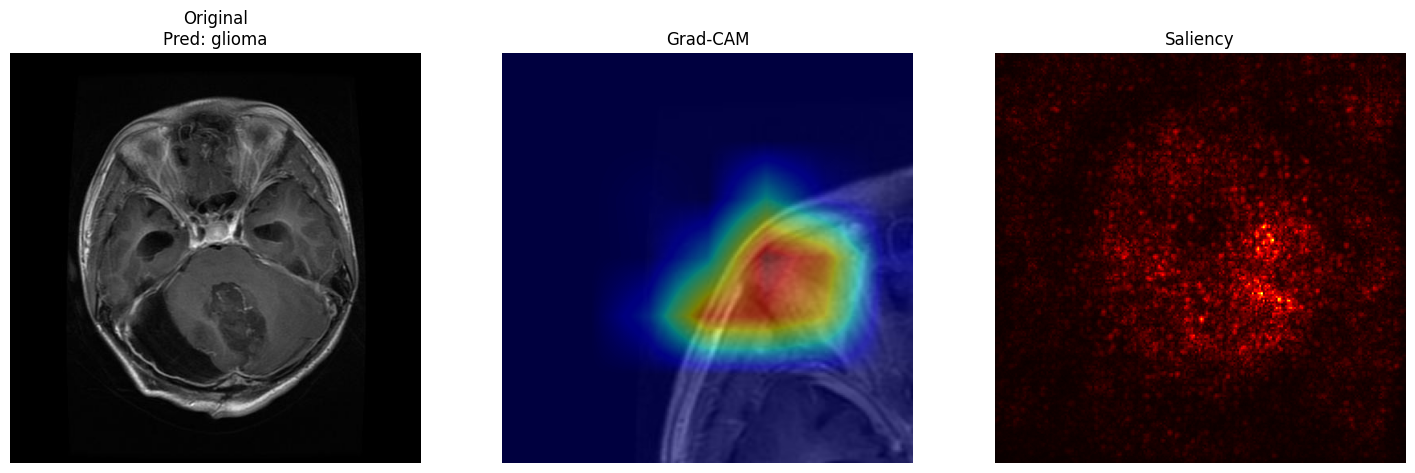


>>> Visualizing on EfficientNet_Transformer_Hybrid


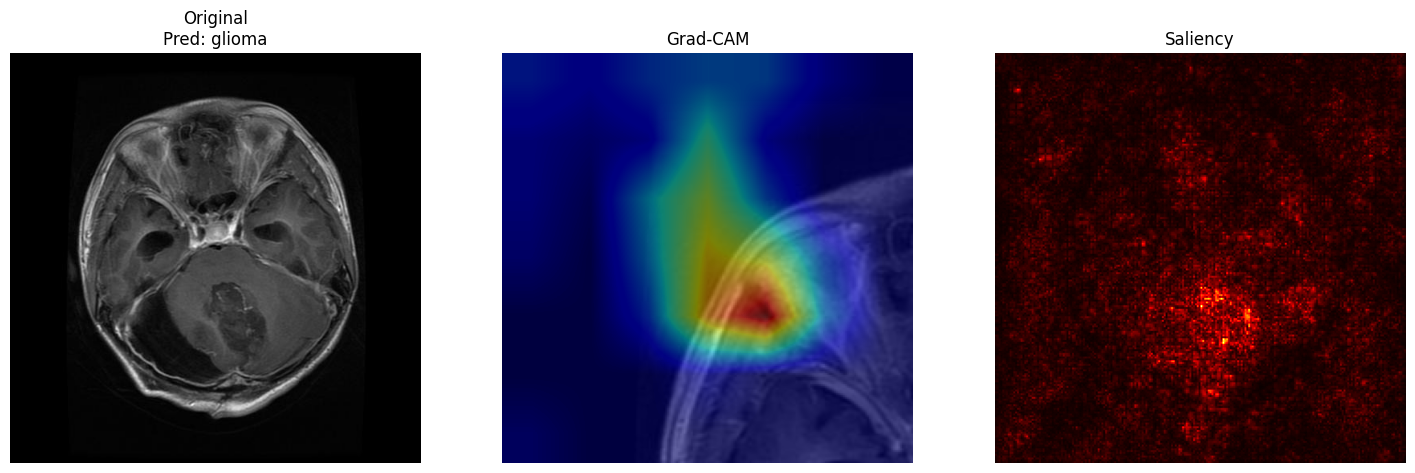

In [27]:
example_path = '/kaggle/input/brain-tumerr/brain tumer/Testing/glioma/Te-glTr_0000.jpg'

for mdl in (model_resnet, model_eff):
    print(f"\n>>> Visualizing on {mdl.__class__.__name__}")
    visualize_gradcam_and_saliency(mdl, example_path, test_transform, class_names)


In [23]:
# Test-Time Augmentation (TTA)
import torch.nn.functional as F
def tta_predict(model, pil_img: Image.Image, base_transform, tta_transforms):
    model.eval()
    probs = []
    with torch.no_grad():
        for trx in tta_transforms:
            inp = trx(pil_img).unsqueeze(0).to(device)
            out = model(inp)
            probs.append(F.softmax(out, dim=1).cpu().numpy())
    return np.mean(probs, axis=0)

tta_transforms = [
    test_transform,
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)] + test_transform.transforms),
    transforms.Compose([transforms.RandomVerticalFlip(p=1.0)]   + test_transform.transforms),
    transforms.Compose([transforms.RandomRotation(15)]          + test_transform.transforms),
]

In [24]:
example_img = Image.open(example_path).convert("RGB")
for mdl, name in [(model_resnet,"ResNet-Hybrid"), (model_eff,"EffNet-Hybrid")]:
    avg_probs = tta_predict(mdl, example_img, test_transform, tta_transforms)
    pred_idx  = int(np.argmax(avg_probs))
    print(f"{name} + TTA prediction:", class_names[pred_idx])

ResNet-Hybrid + TTA prediction: glioma
EffNet-Hybrid + TTA prediction: glioma
